### Logistic regression models of $C_t$ given $\textbf{X}$.


In [7]:
from experiments.simulation import forward_simulation
from sklearn.linear_model import LogisticRegression
from hmm.types import FloatArray

import seaborn as sns
import pandas as pd
import numpy as np

Simple function for getting simulated data as sample pairs $((C_1, ..., C_T), \textbf{X})$

In [3]:
def evaluate_logistic_regression_model(
    n: int,
    t: int,
    evaluation_T: int = 1000,
    iterations: int = 100,
    **kwargs
) -> tuple[list[list[int]], list[FloatArray]]:
    # Datas.
    evaluation_c, _, evaluation_x = forward_simulation(n, evaluation_T)
    accuracies: list[float] = []

    for _ in range(1, iterations):
        c, _, x = forward_simulation(n, t)
        # Fit log regression 
        clf = LogisticRegression(**kwargs).fit(x, c)
        # predict accuracy 
        accuracy = clf.score(evaluation_x, evaluation_c)
        # save predicted accuracy into array
        accuracies.append(accuracy)

        # Fit log regression 
        clf = LogisticRegression(**kwargs).fit(x, c)

        # predict accuracy 
        accuracy = clf.score(evaluation_x, evaluation_c)
        # save predicted accuracy into array
        accuracies.append(accuracy)

    return accuracies # afterwards we can make histogram of this

In [4]:
t_values = [50, 100, 500, 1000]

accuracies_for_ts = [
    evaluate_logistic_regression_model(n=8, t=t)
        for t in t_values
]

/home/init0/miniconda3/envs/hmm/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/init0/miniconda3/envs/hmm/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

In [5]:
df

NameError: name 'df' is not defined

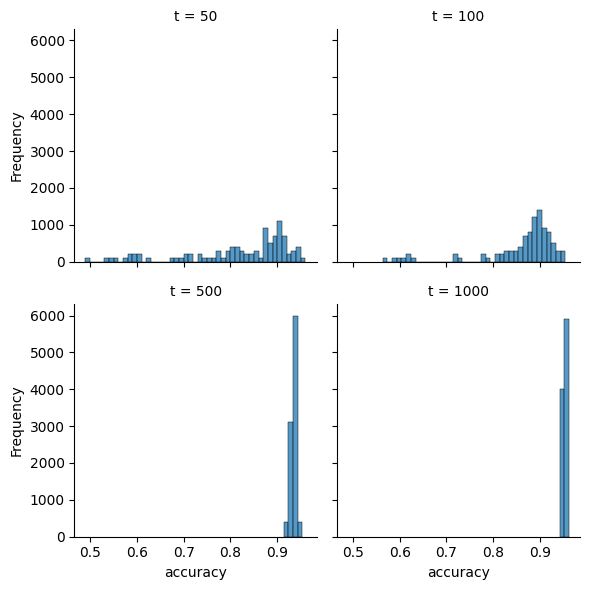

In [22]:
df = pd.DataFrame(accuracies_for_ts).T

# Add column names to the DataFrame
df.columns = ['50', '100', '500', '1000']

# Create a FacetGrid with a separate subplot for each value of t
g = sns.FacetGrid(df.melt(var_name='t', value_name='accuracy'), col='t', col_wrap=2)
# Set the y-axis limit of each subplot to be between 0 and 1
for ax in g.axes.flat:
		# Add more xticks
		ax.set_xticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
		ax.set_xticklabels(['0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
		ax.set(xlabel='Accuracy')	
g.map(sns.histplot, 'accuracy', binwidth=0.01, stat="frequency")